In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
dataSetDir = '/content/drive/My Drive/SWM/Subtask_A/'

In [ ]:
import pandas as pd
from tqdm import notebook

In [ ]:
file2013 = open(dataSetDir + 'twitter-2013train-A.txt')
file2014 = open(dataSetDir + 'twitter-2014sarcasm-A.txt')
file2015 = open(dataSetDir + 'twitter-2015train-A.txt')
file2016 = open(dataSetDir + 'twitter-2016train-A.txt')
file2013dev = open(dataSetDir + 'twitter-2013dev-A.txt')
file2016dev = open(dataSetDir + 'twitter-2016dev-A.txt')
lines = file2013.readlines()
lines += file2014.readlines()
lines += file2015.readlines()
lines += file2016.readlines()
lines += file2013dev.readlines()
lines += file2016dev.readlines()
print('Number of lines in txt file: {}'.format(len(lines)))

labelsTrain = []
tweetsTrain = []

for line in notebook.tqdm(lines):
    line = line.split()
    labelsTrain.append(line[1])
    line = line[2:]
    tweet = ' '.join(line)
    tweetsTrain.append(tweet)
dfTrain = pd.DataFrame(list(zip(tweetsTrain, labelsTrain)), columns =['tweets', 'labels']) 
dfTrain = dfTrain.sample(frac=1).reset_index(drop=True)
dfTrain = dfTrain[:int(len(dfTrain)*0.9)]
dfTest = dfTrain[int(len(dfTrain)*0.9):]

Number of lines in txt file: 9684


  0%|          | 0/9684 [00:00<?, ?it/s]

  0%|          | 0/16173 [00:00<?, ?it/s]

array(['positive', 'negative', 'neutral'], dtype=object)

In [ ]:
dfTrain.groupby('labels').size() 

labels
negative    2387
neutral     6882
positive    6904
dtype: int64

In [ ]:
dfTrain.head()

,tweets,labels
0,Gas by my house hit $3.39!!!! I\u2019m going t...,positive
1,Theo Walcott is still shit\u002c watch Rafa an...,negative
2,its not that I\u2019m a GSP fan\u002c i just h...,negative
3,Iranian general says Israel\u2019s Iron Dome c...,negative
4,Tehran\u002c Mon Amour: Obama Tried to Establi...,neutral


In [ ]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 6.7 kB/s 
     |████████████████████████████████| 439 kB 65.2 MB/s 
     |████████████████████████████████| 1.7 MB 27.1 MB/s 
     |████████████████████████████████| 6.0 MB 40.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully 

In [ ]:
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import pydotplus as pyd

import keras
from keras.utils import plot_model, pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate
from nltk.stem import PorterStemmer
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dfTrain['labels'] = dfTrain['labels'].apply(lambda x: ['negative', 'positive', 'neutral'].index(x))
dfTest['labels'] = dfTest['labels'].apply(lambda x: ['negative', 'positive', 'neutral'].index(x))
dfTrain.head()

In [ ]:
def remove_stop_words(df, target_col_name, new_col_name):
  df[new_col_name] = df[target_col_name].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords.words('english')]))
  return df

def remove_punctuation(df, target_col_name, new_col_name):
  df[new_col_name] = df[target_col_name].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))
  return df

def stem_text(df, target_col_name, new_col_name):
  ps = PorterStemmer()
  df[new_col_name] = df[target_col_name].apply(lambda x: " ".join([ps.stem(word) for word in x.split()]))
  return df

dfTrain = stem_text(dfTrain, 'tweets', 'tweets')
dfTrain = remove_stop_words(dfTrain, 'tweets', 'tweets')
dfTrain = remove_punctuation(dfTrain, 'tweets', 'tweets')
dfTrain.head()

,tweets,labels
0,thi saturday itu2019 time classic cherri moon ...,2
1,world music festiv rock citi saturday maria mu...,2
2,proud ladi famili group kremlin today place 3r...,1
3,persona 4 golden arriv north america playstat ...,2
4,sacha baron cohen lesbian sbc 2 make film man ...,2


In [ ]:
dfTest = stem_text(dfTest, 'tweets', 'tweets')
dfTest = remove_stop_words(dfTest, 'tweets', 'tweets')
dfTest = remove_punctuation(dfTest, 'tweets', 'tweets')

In [ ]:
X_train = dfTrain['tweets'].values[:int(len(dfTrain['tweets'].values)*0.8)]
y_train = dfTrain['labels'].values[:int(len(dfTrain['labels'].values)*0.8)]
X_test = dfTrain['tweets'].values[int(len(dfTrain['tweets'].values)*0.8):]
y_test = dfTrain['labels'].values[int(len(dfTrain['labels'].values)*0.8):]
print(len(X_train), len(X_test))

6972 1743


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 1039, 1: 2620, 2: 3313}

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 285, 1: 657, 2: 801}

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1
print(vocab_size)

20265


In [ ]:
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

In [ ]:
max_length = 140
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [ ]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tqdm

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()

f = open('/content/drive/MyDrive/SWM/embedding/glove.twitter.27B.200d.txt')
for line in tqdm.tqdm(f):
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

1193514it [01:21, 14702.04it/s]

Loaded 1193514 word vectors.


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
    except:
        embedding_vector = [0]*200
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(20265, 200)

In [ ]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(3, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 140)]             0         
                                                                 
 embedding (Embedding)       (None, 140, 200)          4053000   
                                                                 
 conv1d (Conv1D)             (None, 137, 50)           40050     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 68, 50)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 100)           15100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 33, 100)          0         
 1D)                                                         

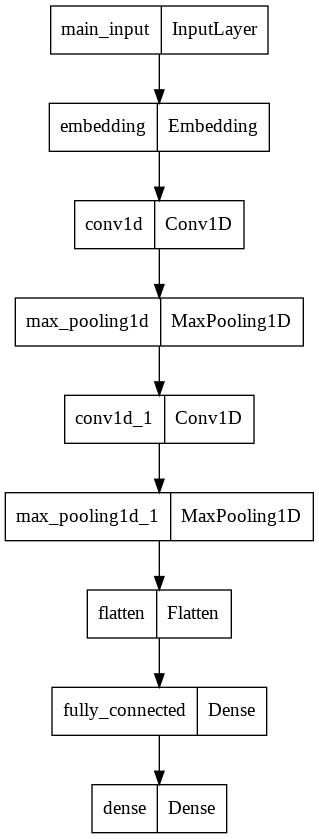

In [ ]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model_01.png')

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("models/sentiment_model.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 10,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])



In [ ]:
h1 = model_01.fit(padded_train, y_train, 
               batch_size=64, 
               epochs=100, 
               verbose=1, callbacks=[checkpoint, earlystop, reduce_lr], 
               validation_split=0.2)

Epoch 1/100
88/88 [==============================] - ETA: 0s - loss: 0.9686 - f1_m: 0.3459 - acc: 0.5241
Epoch 1: val_f1_m improved from -inf to 0.55805, saving model to models/sentiment_model.h5
88/88 [==============================] - 11s 18ms/step - loss: 0.9686 - f1_m: 0.3459 - acc: 0.5241 - val_loss: 0.8781 - val_f1_m: 0.5580 - val_acc: 0.6014 - lr: 0.0010
Epoch 2/100
82/88 [==========================>...] - ETA: 0s - loss: 0.7912 - f1_m: 0.6113 - acc: 0.6500
Epoch 2: val_f1_m did not improve from 0.55805
88/88 [==============================] - 0s 6ms/step - loss: 0.7932 - f1_m: 0.6112 - acc: 0.6502 - val_loss: 0.8790 - val_f1_m: 0.5336 - val_acc: 0.5778 - lr: 0.0010
Epoch 3/100
80/88 [==========================>...] - ETA: 0s - loss: 0.6191 - f1_m: 0.7290 - acc: 0.7412
Epoch 3: val_f1_m improved from 0.55805 to 0.62246, saving model to models/sentiment_model.h5
88/88 [==============================] - 1s 6ms/step - loss: 0.6224 - f1_m: 0.7264 - acc: 0.7396 - val_loss: 0.8505 - v

In [ ]:
score_1 = model_01.evaluate(padded_test, y_test)
score_1

55/55 [==============================] - 1s 10ms/step - loss: 2.1447 - f1_m: 0.5955 - acc: 0.6013


[2.144709587097168, 0.5955212116241455, 0.6012622117996216]

55/55 [==============================] - 0s 3ms/step
[[112  49 124]
 [ 46 364 247]
 [ 92 137 572]]


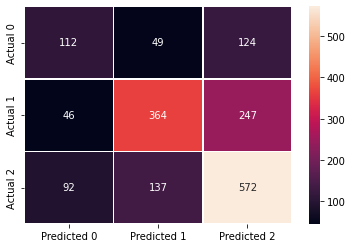

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'], 
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2'])

55/55 [==============================] - 0s 4ms/step


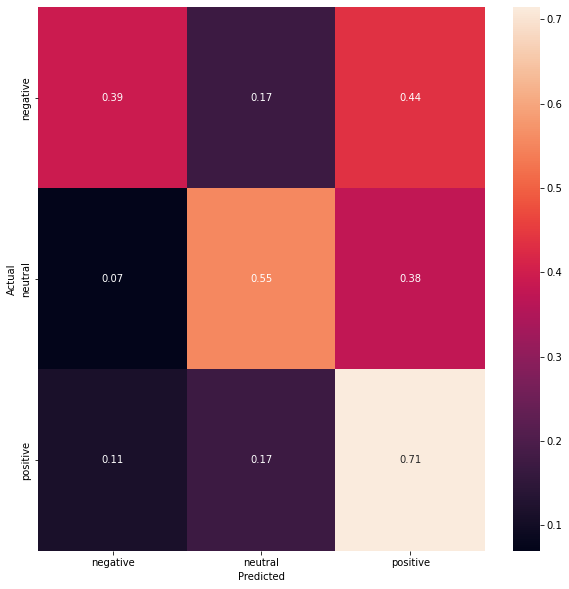

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

target_names = ['negative', 'neutral', 'positive']
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_test), axis=1))
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, f1_score, precision_score, recall_score
print(f1_score(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_test), axis=1), average='weighted'))
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_test), axis=1)))
print(precision_score(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_test), axis=1), average="weighted"))
print(recall_score(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_test), axis=1), average="weighted"))

55/55 [==============================] - 0s 2ms/step
0.5972588310054748
55/55 [==============================] - 0s 2ms/step
0.6012621916236374
55/55 [==============================] - 0s 2ms/step
0.6014692652528834
55/55 [==============================] - 0s 2ms/step
0.6012621916236374


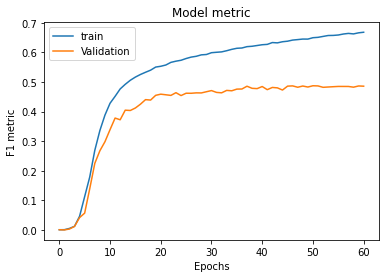

In [ ]:
plt.plot(h1.history['f1_m'][1:])
plt.plot(h1.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('Epochs')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

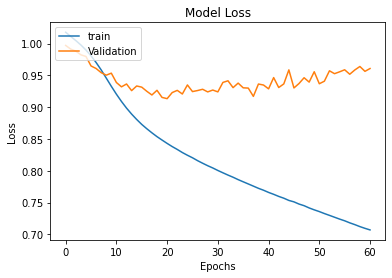

In [ ]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','Validation'], loc='upper left')
plt.show()